## P5.1 Model Prep, Modelling, Evaluation & Recommendations

### Model Prep
---
In model learning, data is usually segregated into
- training set; where model learns from the pattern within this set of data,
- validate set; where model or group of models are evaluated. This is the performance the model is expected to have on unseen data.
- test set; the best performing model is then shortlisted and tested on the test set.
 
Model workflow steps:
- first split data into i) train and test set, then split the train set into train subsets and validate subsets.
- only fit on the train set then score on validate set. (Similar principle applies on test set). 
- evaluate model
This would prevent dataleakage (inadvertent countvectorize (a transformer) the entire data before doing train-test-split).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# always be stylish
plt.style.use('ggplot')

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [10]:
# Setting - display all columns
pd.set_option('display.max_columns', None)

In [11]:
# Read in cleaned featured engineered data
dframe = pd.read_csv('../assets/wordok.csv',encoding="ISO-8859-1",index_col=0)

In [4]:
dframe.shape

(32521, 24)

In [5]:
dframe.head(2)

,eventid,iyear,imonth,iday,country,region,lat,lon,crit1,crit2,crit3,success,suicide,atkmode,targtype,targnat,gname,motive,indiv,weaptype,nkill,nwound,property,bomb
0,197001010002,1970,1,1,United States,North America,37.005105,-89.176269,1,1,1,1,0,armed assault,police,united states,black nationalists,to protest the cairo illinois police deparment,0,firearms,0,0,1,0
1,197001020003,1970,1,2,United States,North America,43.076592,-89.412488,1,1,1,1,0,facility attack,military,united states,new year's gang,to protest the war in vietnam and the draft,0,incendiary,0,0,1,0


In [6]:
# Create Train-Test split (80-20 split)
# X is selftext. y is googlehome.
X_train,X_test,y_train,y_test = train_test_split(dframe[['motive']],dframe['bomb'],test_size=0.20,\
                                                 stratify=dframe['bomb'],\
                                                 random_state=42)

In [7]:
# Equal proportion of classes split across train and test set
print(y_train.value_counts(normalize=True))
y_test.value_counts(normalize=True)

0    0.523524
1    0.476476
Name: bomb, dtype: float64


0    0.523444
1    0.476556
Name: bomb, dtype: float64

In [8]:
# Create Train-Validate subsets (80-20 split) from the parent Train set
# X is selftext. y is googlehome.
X_trainsub,X_validate,y_trainsub,y_validate = train_test_split(X_train[['motive']],y_train,test_size=0.20,\
                                                           stratify=y_train,random_state=42)

In [9]:
# Lines of text in train set, validate set and test set
row_trainsub = X_trainsub.shape[0]
row_validate = X_validate.shape[0]
row_test = X_test.shape[0]
print(f"Lines in train set: {row_trainsub}")
print(f"Lines in validate set: {row_validate}")
print(f"Lines in test set: {row_test}")

Lines in train set: 20812
Lines in validate set: 5204
Lines in test set: 6505


In [10]:
# Instantiate porterstemmer
p_stemmer = PorterStemmer()

In [45]:
# Create the list of custom stopwords
# Built upon nltk stopwords (english)
"""Define the stopword lists"""
s_words = stopwords.words('english')
# Instantiate the custom list of stopwords for modelling from P5_01
own_stop = ['shiite','police', 'iraq' 'sunni', 'npa', 'maoist', 'day', 'maoists', 'ida', 'qa', 'islamic', 'isil',\
            'shabaab','levant','bombing','hartal','communist','bangladesh','cpi','2015','january','bangdad','iraqi',\
            'pakistan','united','aqi','india','bombings','thailand','tripoli','shiites','janmukti','puerto','bomb',\
            'morcha','planted','ttp','israeli','african', 
            'revenge','attempting','peace','upcoming','said','recent','attempt','time','religious','war','general',\
            'station','note','liberation','officials','president','groups','ltte','april','extremists','armed',\
            'leave','states','operations','2014','called','algeria','2013','related','authorities','algerian',\
            'parliamentary','national','alleged','source','death','recently','spokesperson','speculate',\
            'reported','area','province','boko','tehrik','al','target','haram','support','protest','held']

In [46]:
# Extend the Stop words
s_words.extend(own_stop)
# Check the addition of firstset_words
s_words[-5:]

['target', 'haram', 'support', 'protest', 'held']

In [47]:
# Define function to convert a raw selftext to a string of words
# The input is a single string (a raw selftext), and 
# The output is a single string (a preprocessed selftext)
# For Stop words with firstset_words and secondset_words

def selftext_to_words(motive_text):
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", motive_text)
    
    # 2. Split into individual words
    words = letters_only.split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(s_words)

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Stemming of words
    meaningful_words = [p_stemmer.stem(w) for w in words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result
    return(" ".join(meaningful_words))

In [48]:
# Initialize an empty list to hold the cleaned texts.

X_trainsub_clean = []
X_validate_clean = []
X_test_clean = []

#For trainsub set
# Instantiate counter.
j = 0
for text in X_trainsub['motive']:
    """Convert text to words, then append to X_trainf_clean."""
    X_trainsub_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Clean & parse {j + 1} of {row_trainsub+row_validate+row_test}.')
    
    j += 1
    
# For validate set
for text in X_validate['motive']:
    """Convert text to words, then append to X_validate_clean."""
    X_validate_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Clean & parse {j + 1} of {row_trainsub+row_validate+row_test}.')
    
    j += 1
    
# For test set
for text in X_test['motive']:
    """Convert text to words, then append to X_test_clean."""
    X_test_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % (row_trainsub+row_validate+row_test) == 0:
        print(f'Clean & parse {j + 1} of {row_trainsub+row_validate+row_test}.')
    
    j += 1

Clean & parse 1000 of 32521.
Clean & parse 2000 of 32521.
Clean & parse 3000 of 32521.
Clean & parse 4000 of 32521.
Clean & parse 5000 of 32521.
Clean & parse 6000 of 32521.
Clean & parse 7000 of 32521.
Clean & parse 8000 of 32521.
Clean & parse 9000 of 32521.
Clean & parse 10000 of 32521.
Clean & parse 11000 of 32521.
Clean & parse 12000 of 32521.
Clean & parse 13000 of 32521.
Clean & parse 14000 of 32521.
Clean & parse 15000 of 32521.
Clean & parse 16000 of 32521.
Clean & parse 17000 of 32521.
Clean & parse 18000 of 32521.
Clean & parse 19000 of 32521.
Clean & parse 20000 of 32521.
Clean & parse 21000 of 32521.
Clean & parse 22000 of 32521.
Clean & parse 23000 of 32521.
Clean & parse 24000 of 32521.
Clean & parse 25000 of 32521.
Clean & parse 26000 of 32521.
Clean & parse 32521 of 32521.


### Baseline accuracy
---
Derive the baseline accuracy so as to be able to determine if the subsequent models are better than the baseline (null) model (predicting the plurality class).

In [49]:
y_test.value_counts(normalize=True)

0    0.523444
1    0.476556
Name: bomb, dtype: float64

The Baseline accuracy is the percentage of the majority class. In this case, the baseline accuracy is 0.48. 
This serves as benchmark for measuring model performance (i.e. model accuracy should be higher than this baseline).
For model evaluation, use:
- `sensitivity` (reduce false negatives) AND
- `ROC-AUC` (measures model's skill in classification)

### Logistic Regression Model
---
Logistic Regression model is explored in this section.

In [50]:
# Set up a pipeline with two stages
# 1.CountVectorizer (transformer)
# 2.LogisticRegression (estimator)

pipe1 = Pipeline([('cvec',CountVectorizer()),\
                 ('logreg',LogisticRegression(random_state=42))\
                ])

In [51]:
# Parameters of pipeline object
pipe1.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='cont

In [52]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Max. no. of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000, 10000
# Min. no. of documents (collection of text) needed to include token: 2, 3
# Max. no. of documents needed to include token: 90%, 95%
# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
# class weight "balanced"; adjust class weights inversely proportional to class frequencies in the input data
pipe1_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000,10_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)],\
    'logreg__max_iter': [500],\
    'logreg__solver':['lbfgs'],\
    'logreg__verbose': [1]
}

In [53]:
# Instantiate GridSearchCV.
"""pipe1 refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""10 folds for cross-validate."""
gs1 = GridSearchCV(pipe1,\
                  param_grid=pipe1_params,\
                  cv=10)

In [54]:
# Fit GridSearch to the cleaned training data.
gs1.fit(X_trainsub_clean,y_trainsub)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [55]:
# Check the results of the grid search

print(f"Best parameters: {gs1.best_params_}")
print(f"Best score: {gs1.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'logreg__max_iter': 500, 'logreg__solver': 'lbfgs', 'logreg__verbose': 1}
Best score: 0.6750910183670841


In [56]:
# Save best model as model_1

model_1 = gs1.best_estimator_

In [57]:
# Score model on train set and validate set
print(f"Accuracy on train set: {model_1.score(X_trainsub_clean, y_trainsub)}")
print(f"Accuracy on validate set: {model_1.score(X_validate_clean, y_validate)}")

Accuracy on train set: 0.7604266769171631
Accuracy on validate set: 0.6781322059953881


Modelling helps with classification as the model accuracy is higher than the baseline accuracy (0.48). The model is overfitted with about 10% drop in test accuracy compared to train accuracy.

In [58]:
# Confusion matrix on the first log reg model
# Pass in true values, predicted values to confusion matrix
# Convert confusion matrix into dataframe
# Positive class (class 1) is bomb
preds = gs1.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1413,1311
Actual bomb,364,2116


The positive class (class 1) refers to `bomb`. False positive means the observation is classified as `bomb` when it is actually `non-bomb`. 
False negative means the observation is classified as `non-bomb` when it is actually `bomb`.


In [59]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds).ravel()

In [60]:
# Summary of metrics for log reg model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.5187
Sensitivity: 0.8532


The Receiver Operating Characteristic (ROC) curve visualizes the overlap between the positive class and negative class as the classification threshold moves from 0 to 1 (i.e. trade-off between sensitivity (or TruePositiveRate) and specificity (1 – FalsePositiveRate). 
As a baseline, a no-skill classifier is expected to give points lying along the diagonal (FPRate = TPRate); (i.e. the closer the curve is to the diagonal line, the less accurate the classifier). 

- Better performing classifiers give curves closer to the top-left corner. 
- The more area under the blue curve, the better separated the class distributions are. 
- Best trade-off between sensitivity and specificity is the top-left point along the ROC curve.

In [61]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validate set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs1.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
11714,0,0.555791
6933,1,0.555791
21031,0,0.074948
29689,0,0.715893
25274,0,0.193212


In [62]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.7460434577945148

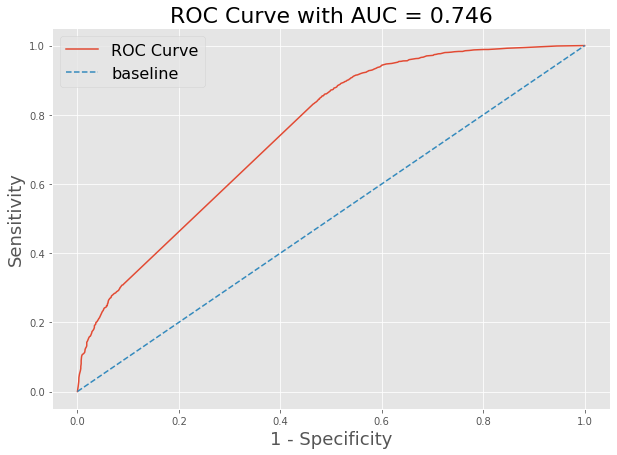

In [63]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed orange line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

An ROC AUC of 1 means the positive and negative populations are perfectly separated and that the model is as good as it can get. The closer the ROC AUC is to 1, the better. (1 is the maximum score.)
Before exploring the stopwords to further potentially improve the classification ability of a model, examine the performance of a Naive Bayes model.

### Naive Bayes Model
---
We explore the Naive Bayes Model, and apply the removal of identifed common overlapped words identified earlier. 

In [64]:
# Set up a pipeline, p2 with two stages
# 1.CountVectorizer (transformer)
# 2.Naive Bayes(multinomial) (estimator)
pipe2 = Pipeline([('cvec',CountVectorizer()),\
                  ('nb',MultinomialNB())\
                 ])

In [65]:
# Parameters of pipeline object
pipe2.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'nb': M

In [66]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000, 10000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe2_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000,10_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [67]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs2 = GridSearchCV(pipe2,\
                  param_grid=pipe2_params,\
                  cv=10)

In [68]:
# Fit GridSearch to the cleaned training data.

gs2.fit(X_trainsub_clean,y_trainsub)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [69]:
# Check the results of the grid search
print(f"Best parameters: {gs2.best_params_}")
print(f"Best score: {gs2.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.6577453433724734


In [70]:
# Save best model as model_2

model_2 = gs2.best_estimator_

In [71]:
# Score model on training set & validate set
print(f"Logistic Regression Model")
print(f"Accuracy on train set: {model_1.score(X_trainsub_clean, y_trainsub)}")
print(f"Accuracy on validate set: {model_1.score(X_validate_clean, y_validate)}")
print()
print(f"Naive Bayes Model")
print(f"Accuracy on train set: {model_2.score(X_trainsub_clean, y_trainsub)}")
print(f"Accuracy on validate set: {model_2.score(X_validate_clean, y_validate)}")

Logistic Regression Model
Accuracy on train set: 0.7604266769171631
Accuracy on validate set: 0.6781322059953881

Naive Bayes Model
Accuracy on train set: 0.6883528733423026
Accuracy on validate set: 0.6593005380476556


The Naive Bayes model is overfitted on the train data, with lower validate accuracy compared to the train accuracy. It doesn't appear to be performing better than the logistic regression model, with a lower validate accuracy. However, compared to the logistic regression model, it has a smaller overfit (approx. 3% overfit). 

We review the sensitivity and specificity, and roc_auc scores next.

In [72]:
# Confusion matrix on the first naive bayes model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds2 = gs2.predict(X_validate_clean)
cm = confusion_matrix(y_validate, preds2)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1386,1338
Actual bomb,435,2045


In [73]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, preds2).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate,preds2).ravel()

In [74]:
# Summary of metrics for naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

Specificity: 0.5088
Sensitivity: 0.8246


In [75]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs2.predict_proba(X_validate_clean)]

pred_df = pd.DataFrame({'validate_values': y_validate,
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
11714,0,0.858199
6933,1,0.858199
21031,0,0.114334
29689,0,0.991767
25274,0,0.002280


In [77]:
# Calculate ROC AUC.
roc_auc_score(pred_df['validate_values'],pred_df['pred_probs'])

0.7272474953815546

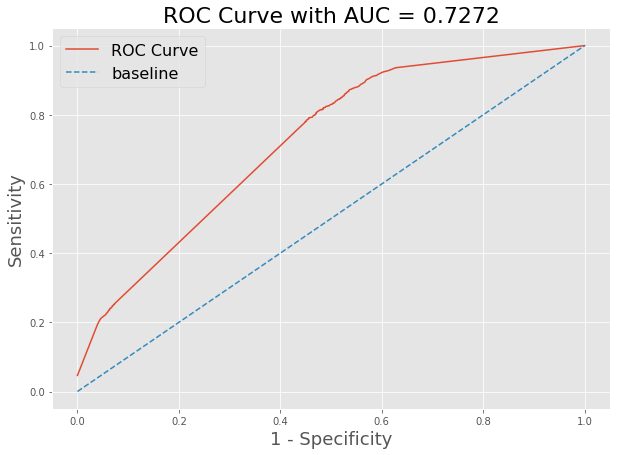

In [78]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed blue line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'validate_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["validate_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The roc_auc of the Naive Bayes model is slightly lower (approx. 2%) than that of logistic regression model.

In [79]:
# Summary of Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.6781, 0.6593],
                          'specificity' : [0.5187, 0.5088],
                          'sensitivity' : [0.8512, 0.8246],
                          'roc_auc' : [0.7460, 0.7272]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['LogReg','NB']
summary_dft

,LogReg,NB
accuracy,0.6781,0.6593
specificity,0.5187,0.5088
sensitivity,0.8512,0.8246
roc_auc,0.7460,0.7272


Prioritization is on correct classification of bomb attack mode as a misclassified actual bomb attack mode could lead to relatively more dire consequences (more casaulties). In this regard, we would want to pick the model with highest True Positive Rate (sensitivity), for as much correct classification of the bomb attack modes as possible. 

Considering 
- both models sensitivity and roc_auc are quite close (within 5%) 
- logistic regression model can only provide the positive class features (unable to examine the words contributing to negative classification and false negative classification,
- NB model can provide both positve and negative class features (false positive and false negative examinable for tuning of model)
- we pick the Naive Bayes model as the production model

Fit NB model on full train set, test on test set, review misclassified samples, tune the production model.

### Deeper Look at Production Model (NB model)
---
For the test accuracy and roc_auc scores, this section examines 
- model performance on test data
- the features that helps with negative (non-bomb) and positive (bomb) classifications,
- what could be the features that lead to misclassifications.

In [80]:
#Initialize an empty list to hold the clean test text.
X_train_clean = []

# Using whole of train set (i.e. trainsub and validate set)
# Instantiate counter.
j = 0
for text in X_train['motive']:
    """Convert text to words, then append to X_trainf_clean."""
    X_train_clean.append(selftext_to_words(text))

In [81]:
# using best parameters discovered above in gs2

# Instantiate our CountVectorizer
cv = CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=3,max_features=10000)

# Fit and transform on whole training data
X_train_cleancv = cv.fit_transform(X_train_clean)

# Transform test data
X_test_cleancv = cv.transform(X_test_clean)

---

In [82]:
# Instantiate model
nb = MultinomialNB()

# Fit model on whole training data
model = nb.fit(X_train_cleancv,y_train)

# Generate predictions from test set
predictions = nb.predict(X_test_cleancv)
print(f"Accuracy on whole test set: {model.score(X_test_cleancv, y_test)}")

Accuracy on whole test set: 0.6733282090699462


In [83]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is bomb
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1800,1605
Actual bomb,520,2580


In [84]:
# return nparray as a 1-D array.
confusion_matrix(y_test, predictions).ravel()

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

# Summary of metrics for naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

# To compute the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in nb.predict_proba(X_test_cleancv)]

pred_df = pd.DataFrame({'test_values': y_test,
                        'pred_probs':pred_proba})

# Calculate ROC AUC.
print(f"roc_auc: {round(roc_auc_score(pred_df['test_values'],pred_df['pred_probs']),4)}")

Specificity: 0.5286
Sensitivity: 0.8323


0.7410603950547108

In [85]:
# Summary of the production NB Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.6593, 0.6733],
                          'specificity' : [0.5088, 0.5286],
                          'sensitivity' : [0.8246, 0.8323],
                          'roc_auc' : [0.7272, 0.7411]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['Whole Train set','Test set']
summary_dft

,Whole Train set,Test set
accuracy,0.6593,0.6733
specificity,0.5088,0.5286
sensitivity,0.8246,0.8323
roc_auc,0.7272,0.7411


There is a slight increase in sensitivity (approx. 1%) and roc_auc (approx. 1%) for the test score of the production model. Model does not appear to be overfitted on the whole train dataset, since the test accuracy is higher than accuracy from the whole train set. We review the top features for positive and negative classifications.

In [86]:
# The Naive Bayes 'feature_log_prob_' is similar to '.coef_ for MultinomialNB' 
# Utilize this to find the top words (features) in the positive and negative class

#prob for positive class
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
#prob for negative class
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
#getting the top features 
pos_top_features = np.take(cv.get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(cv.get_feature_names(), neg_class_prob_sorted)

In [87]:
# List of top 50 words that helps in 'bomb' (positive) classification
print(pos_top_features[:50])

['bangla' 'asg demand' 'maoist believ' 'to suspend' 'as upon' 'cloth'
 'suspend oper' 'as suicid' 'as sectarian' 'to treat' 'of start'
 'as protest' 'maoist accus' 'to util' 'to violenc' 'maoist abduct'
 'close of' 'maoist chand' 'intent to' 'of tauseef' 'of theft'
 'impetu for' 'impetu' 'follow citizen' 'follow militari'
 'assail allegedli' 'to south' 'prosecut main' 'assail accus' 'romano an'
 'aspir for' 'class' 'ask to' 'ask them' 'eight demand' 'follow their'
 'to speak' 'nigeria presidenti' 'prosecut' 'collabor of' 'rwanda fdlr'
 'eggon commun' 'man wa' 'promot within' 'supremacist narr' 'treason'
 'treat' 'tree' 'man for' 'suprem court']


In [88]:
# List of top 50 words that helps in 'non-bomb' (negative) classification
print(neg_top_features[:50])

['properti belong' 'birth an' 'birth' 'qud' 'rahami' 'rakhin includ'
 'beyond' 'birthday of' 'receiv support' 'referendum which' 'reflect on'
 'reinstat apartheid' 'rel littl' 'religi figur' 'remain unansw'
 'recent violenc' 'public trust' 'public confid' 'provinc howev'
 'price and' 'box match' 'prior furthermor' 'bomb target' 'bomb occur'
 'bomb may' 'bomb had' 'pro unit' 'bomb at' 'filanbanco had' 'blown up'
 'protest dure' 'protest republ' 'provinc face' 'blast wa' 'replac it'
 'report thi' 'resist and' 'befor corsica' 'school becaus' 'school if'
 'sdla' 'sdla claim' 'second year' 'sectarian and' 'secur campaign'
 'be fight' 'be blown' 'seek vengeanc' 'seguimento' 'seguimento spain']


### Review Misclassified samples (NB model)

Recap on the false classifications:

**False Positive**: Predicted as bomb post but is actually non-bomb attack mode.
**False Negative**: Predicted as non-bomb post but is actually bomb attack mode. 
To gain insights into what are the words that led to misclassification of attack mode, we further compare the words with the list of words that are strongly associated with the correct classes. 

Compare common words in :
- false positive with the words in true positive class,
- false negative with the words in true negative class

In [89]:
# Pass y_test (pandas series) into dataframe first
# in order to use the original selftext indexes for traceability
actual = pd.Series(y_test)
df_rvw = actual.to_frame()

# Create column of predicted classes from Naive Bayes model
df_rvw['predicted_bomb'] = predictions

# Include the selftext data
df_rvw['motive'] = X_test_clean

# Review the dataframe
df_rvw.head()

,bomb,predicted_bomb,motive
15319,1,1,the specif motiv for the attack is unknown
13349,0,0,the headmast wa taken hostag in order to forc ...
18915,1,0,the specif motiv for the attack is unknown how...
15320,1,1,the specif motiv for the attack is unknown
5501,0,0,the attack wa meant to assassin the governor o...


In [90]:
# Index of misclassified classes
row_ids = df_rvw[df_rvw['bomb'] != df_rvw['predicted_bomb']].index
row_ids

Int64Index([18915,  8515, 13471,  8642,    88,  1767, 11863,  3922,   126,
            19346,
            ...
             2311, 15827, 20020, 13124, 13614, 14932, 14740,  4135, 30284,
             7187],
           dtype='int64', length=2125)

In [91]:
# Create sub-dataframes of false positive and false negative classifications
df_msc = pd.DataFrame(df_rvw[df_rvw['bomb'] != df_rvw['predicted_bomb']])
df_fp = pd.DataFrame(df_msc.loc[df_msc['predicted_bomb'] == 0])
df_fn = pd.DataFrame(df_msc.loc[df_msc['predicted_bomb'] == 1])

In [92]:
# Empty list to hold false positive words
fp_words = []
# Split string in false positive selftext to individual words
# Populate the empty list
for i in df_fp.index:
    words = df_fp['motive'][i].split()
    fp_words.extend(words)

In [93]:
# Empty list to hold false negative words
fn_words = []
# Split string in false positive selftext to individual words
# Populate the empty list
for i in df_fn.index:
    words = df_fn['motive'][i].split()
    fn_words.extend(words)

In [94]:
# Convert numpy array of words stongly associated with bomb text into a list
pos_list = pos_top_features.tolist()
# Convert numpy array of words stongly associated with non-bomb text into a list
neg_list = neg_top_features.tolist()

In [95]:
# Print the words that likely contributed to false positive classification
print(set(fp_words) & set(pos_list))

{'heed', 'warn', 'util', 'rural', 'egyptian', 'child', 'suspens', 'cpn', 'aqim', 'serb', 'work', 'libya', 'jammu', 'balochi', 'ideal', 'tamil', 'morsi', 'respond', 'barack', 'second', 'houthi', 'belief', 'russian', 'fulfil', 'european', 'bu', 'arabian', 'mobil', 'news', 'mean', 'island', 'infertil', 'help', 'muslim', 'individu', 'remov', 'syria', 'suspicion', 'amid', 'enter', 'than', 'obama', 'clash', 'unclear', 'blast', 'link', 'leader', 'fellow', 'did', 'south', 'reduct', 'possibl', 'run', 'peshmerga', 'destabil', 'cephesi', 'florida', 'rebel', 'furthermor', 'civilian', 'drive', 'as', 'nepali', 'allegedli', 'off', 'implement', 'past', 'cite', 'man', 'seen', 'block', 'haq', 'regim', 'anoth', 'milit', 'hous', 'gave', 'faction', 'coerc', 'spokesman', 'martyr', 'poster', 'no', 'pro', 'taliban', 'wa', 'illeg', 'activ', 'garo', 'distract', 'mend', 'kenyan', 'jihad', 'explos', 'polici', 'even', 'serv', 'basqu', 'milf', 'negoti', 'although', 'actual', 'issu', 'evid', 'equip', 'chapter', 'ha'

In [96]:
# Print the words that likely contributed to false negative classification
print(set(fn_words) & set(neg_list))

{'heed', 'warn', 'histor', 'governor', 'pakistani', 'turkish', 'intellig', 'auster', 'gener', 'east', 'ite', 'among', 'rage', 'life', 'celebr', 'death', 'republican', 'assert', 'egyptian', 'maintain', 'their', 'post', 'control', 'resid', 'north', 'so', 'calcul', 'string', 'pattani', 'work', 'libya', 'york', 'west', 'jammu', 'arabia', 'statement', 'arafat', 'laden', 'alleg', 'panchayat', 'drug', 'separatist', 'burn', 'support', 'tamil', 'campaign', 'anti', 'mazioti', 'islam', 'cotabato', 'divis', 'morsi', 'belt', 'state', 'conduct', 'pij', 'second', 'belief', 'week', 'suspect', 'soldier', 'russian', 'rohingya', 'said', 'pattern', 'desh', 'feder', 'direct', 'palestinian', 'under', 'blockad', 'sweep', 'separ', 'report', 'over', 'arabian', 'congress', 'neighborhood', 'threaten', 'oklahoma', 'protect', 'news', 'express', 'wave', 'offens', 'interior', 'colleg', 'nation', 'announc', 'newli', 'chang', 'guard', 'public', 'carri', 'muslim', 'out', 'aid', 'stanc', 'myanmar', 'those', 'individu', 

The removal of such words could help in reduction of false positives and false negatives. However, there is a limit to how much of these words can be removed. Care should be excercised to not overtune the model such that it loses it's generalizability and ends up with increased false positives and false negatives in the predictions. Explore the effects of removing 100 such words (leading to misclassification) for both false positive and false negative classes.


Examine effect of model performance with removal of the identified words leading to false classifications?

In [97]:
# Create 1st set stopword
own_stopfp = ['heed', 'warn', 'util', 'rural', 'egyptian', 'child', 'suspens', 'cpn', 'aqim', 'serb', 'work', 'libya',\
             'jammu', 'balochi', 'ideal', 'tamil', 'morsi', 'respond', 'barack', 'second', 'houthi', 'belief', 'russian',\
             'fulfil', 'european', 'bu', 'arabian', 'mobil', 'news', 'mean', 'island', 'infertil', 'help', 'muslim',\
             'individu', 'remov', 'syria', 'suspicion', 'amid', 'enter', 'than', 'obama', 'clash', 'unclear', 'blast',\
             'link', 'leader', 'fellow', 'did', 'south', 'reduct', 'possibl', 'run', 'peshmerga', 'destabil', 'cephesi',\
             'florida', 'rebel', 'furthermor', 'civilian', 'drive', 'as', 'nepali', 'allegedli', 'off', 'implement',\
             'past', 'cite', 'man', 'seen', 'block', 'haq', 'regim', 'anoth', 'milit', 'hous', 'gave', 'faction',\
             'coerc', 'spokesman', 'martyr', 'poster', 'no', 'pro', 'taliban', 'wa', 'illeg', 'activ', 'garo', 'distract',\
             'mend', 'kenyan', 'jihad', 'explos', 'polici', 'even', 'serv', 'basqu', 'milf', 'negoti']

In [98]:
# Create 2nd set stopword
own_stopfn = ['heed', 'warn', 'histor', 'governor', 'pakistani', 'turkish', 'intellig', 'auster', 'gener', 'east',\
              'ite', 'among', 'rage', 'life', 'celebr', 'death', 'republican', 'assert', 'egyptian', 'maintain',\
              'their', 'post', 'control', 'resid', 'north', 'so', 'calcul', 'string', 'pattani', 'work', 'libya',\
              'york', 'west', 'jammu', 'arabia', 'statement', 'arafat', 'laden', 'alleg', 'panchayat', 'drug',\
              'separatist', 'burn', 'support', 'tamil', 'campaign', 'anti', 'mazioti', 'islam', 'cotabato', 'divis',\
              'morsi', 'belt', 'state', 'conduct', 'pij', 'second', 'belief', 'week', 'suspect', 'soldier', 'russian',\
              'rohingya', 'said', 'pattern', 'desh', 'feder', 'direct', 'palestinian', 'under', 'blockad', 'sweep',\
              'separ', 'report', 'over', 'arabian', 'congress', 'neighborhood', 'threaten', 'oklahoma', 'protect',\
              'news', 'express', 'wave', 'offens', 'interior', 'colleg', 'nation', 'announc', 'newli', 'chang', 'guard',\
              'public', 'carri', 'muslim', 'out', 'aid', 'stanc', 'myanmar', 'those']

In [99]:
# Extend the Stop words
s_words.extend(own_stopfp)
s_words.extend(own_stopfn)
# Check the addition of firstset_words
s_words[-5:]

['out', 'aid', 'stanc', 'myanmar', 'those']

In [106]:
def selftext_to_wordsr(motive_text):
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", motive_text)
    
    # 2. Split into individual words
    words = letters_only.split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(s_words)

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Stemming of words
    meaningful_words = [p_stemmer.stem(w) for w in words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result
    return(" ".join(meaningful_words))

In [107]:
#Initialize an empty list to hold the clean test text.
X_train_cleanr = []
X_test_cleanr = []

# Using whole of train set (i.e. trainsub and validate set)
for text in X_train['motive']:
    """Convert text to words, then append to X_trainf_cleanr."""
    X_train_cleanr.append(selftext_to_wordsr(text))
    
# For test set
for text in X_test['motive']:
    """Convert text to words, then append to X_test_cleanr."""
    X_test_cleanr.append(selftext_to_wordsr(text))

In [108]:
# Instantiate our CountVectorizer
cv = CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=3,max_features=10000)

# Fit and transform on whole training data
X_train_cleancvr = cv.fit_transform(X_train_cleanr)

# Transform test data
X_test_cleancvr = cv.transform(X_test_cleanr)

In [122]:
# Instantiate model
nb_prod = MultinomialNB()

# Fit model on whole training data
model_nbprod = nb_prod.fit(X_train_cleancvr,y_train)

# Generate predictions from test set
pred_nbprod = nb_prod.predict(X_test_cleancvr)
print(f"Accuracy on whole test set: {model_nbprod.score(X_test_cleancvr, y_test)}")

Accuracy on whole test set: 0.6733282090699462


In [123]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
cm = confusion_matrix(y_test, pred_nbprod)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1800,1605
Actual bomb,520,2580


In [124]:
# return nparray as a 1-D array.
confusion_matrix(y_test, pred_nbprod).ravel()

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, pred_nbprod).ravel()

# Summary of metrics for naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

# To compute the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in nb_prod.predict_proba(X_test_cleancvr)]

pred_df = pd.DataFrame({'test_values': y_test,
                        'pred_probs':pred_proba})

# Calculate ROC AUC.
print(f"roc_auc: {round(roc_auc_score(pred_df['test_values'],pred_df['pred_probs']),4)}")

Specificity: 0.5286
Sensitivity: 0.8323
roc_auc: 0.7411


In [125]:
# Summary of the production NB Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.6733, 0.6733],
                          'specificity' : [0.5286, 0.5286],
                          'sensitivity' : [0.8323, 0.8323],
                          'roc_auc' : [0.7411, 0.7411]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['NB model','NB model (addn stpwrds removed)']
summary_dft

,NB model,NB model (addn stpwrds removed)
accuracy,0.6733,0.6733
specificity,0.5286,0.5286
sensitivity,0.8323,0.8323
roc_auc,0.7411,0.7411


The NB model with the 100 misclassed word features removed has negligible effect to the model performance. In this aspect, review the performance of the log reg model as the production model.

In [131]:
# Instantiate model
lr_prod = LogisticRegression(random_state=42,solver='lbfgs',max_iter=500)

# Fit model on whole training data (without addn set of stopwords removed in NB model)
model_lrprod = lr_prod.fit(X_train_cleancv,y_train)

# Generate predictions from test set
pred_lrprod = lr_prod.predict(X_test_cleancv)
print(f"Accuracy on whole test set: {round(model_lrprod.score(X_test_cleancv, y_test),4)}")

Accuracy on whole test set: 0.6898


In [129]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is bomb
cm = confusion_matrix(y_test, pred_lrprod)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1826,1579
Actual bomb,439,2661


In [130]:
# return nparray as a 1-D array.
confusion_matrix(y_test, pred_lrprod).ravel()

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, pred_lrprod).ravel()

# Summary of metrics for naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

# To compute the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr_prod.predict_proba(X_test_cleancv)]

pred_df = pd.DataFrame({'test_values': y_test,
                        'pred_probs':pred_proba})

# Calculate ROC AUC.
print(f"roc_auc: {round(roc_auc_score(pred_df['test_values'],pred_df['pred_probs']),4)}")

Specificity: 0.5363
Sensitivity: 0.8584
roc_auc: 0.762


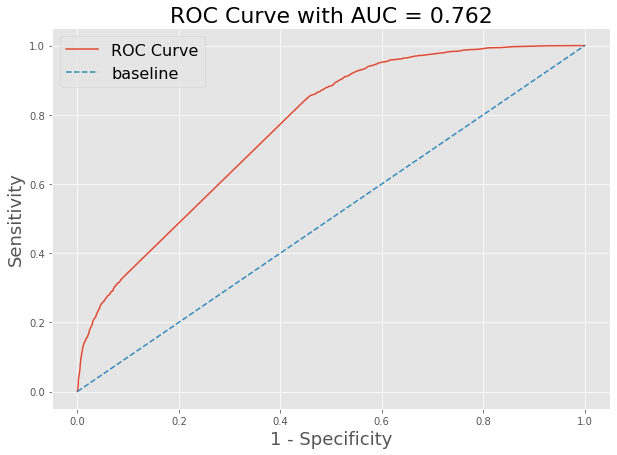

In [134]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed blue line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'test_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'test_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["test_values"], pred_df["pred_probs"]),4)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [132]:
# Summary of the production NB Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.6733, 0.6733,0.6898],
                          'specificity' : [0.5286, 0.5286,0.5363],
                          'sensitivity' : [0.8323, 0.8323,0.8584],
                          'roc_auc' : [0.7411, 0.7411,0.762]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['NB model','NB model (addn stpwrds removed)','LogReg model']
summary_dft

,NB model,NB model (addn stpwrds removed),LogReg model
accuracy,0.6733,0.6733,0.6898
specificity,0.5286,0.5286,0.5363
sensitivity,0.8323,0.8323,0.8584
roc_auc,0.7411,0.7411,0.7620


### Topic Modelling using LDA

In [2]:
import sys
import re
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

## ?? should i have remove these stop words?

In [3]:
# Instantiate the custom list of stopwords for modelling from P5_01
own_stop = ['shiite','police', 'iraq' 'sunni', 'npa', 'maoist', 'day', 'maoists', 'ida', 'qa', 'islamic', 'isil',\
            'shabaab','levant','bombing','hartal','communist','bangladesh','cpi','2015','january','bangdad','iraqi',\
            'pakistan','united','aqi','india','bombings','thailand','tripoli','shiites','janmukti','puerto','bomb',\
            'morcha','planted','ttp','israeli','african', 
            'revenge','attempting','peace','upcoming','said','recent','attempt','time','religious','war','general',\
            'station','note','liberation','officials','president','groups','ltte','april','extremists','armed',\
            'leave','states','operations','2014','called','algeria','2013','related','authorities','algerian',\
            'parliamentary','national','alleged','source','death','recently','spokesperson','speculate',\
            'reported','area','province','boko','tehrik','al','target','haram','support','protest','held']
# Extend the stop words
stop_words.extend(own_stop)

In [14]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = dframe.motive.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['to', 'protest', 'the', 'cairo', 'illinois', 'police', 'deparment']]


In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    # use 'en_core_web_sm' in place of 'en' 
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [16]:
len(data_ready)

32521

### ?? Change the number of topics below here

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.136*"state" + 0.072*"claim" + 0.059*"victim" + 0.059*"attack" + '
  '0.059*"carry" + 0.055*"incident" + 0.047*"responsibility" + 0.035*"also" + '
  '0.026*"accuse" + 0.024*"response"'),
 (1,
  '0.312*"however" + 0.070*"suspect" + 0.069*"election" + 0.040*"violence" + '
  '0.038*"large" + 0.038*"trend" + 0.036*"part" + 0.031*"may" + '
  '0.030*"schedule" + 0.025*"member"'),
 (2,
  '0.055*"government" + 0.055*"occur" + 0.043*"assailant" + 0.043*"demand" + '
  '0.028*"order" + 0.019*"leader" + 0.018*"ransom" + 0.017*"warn" + '
  '0.014*"follow" + 0.014*"arrest"'),
 (3,
  '0.241*"unknown" + 0.239*"specific" + 0.238*"motive" + 0.120*"attack" + '
  '0.050*"posit" + 0.007*"coincide" + 0.004*"noted" + 0.004*"posited" + '
  '0.003*"provincial" + 0.003*"army"')]


In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2500,"state, claim, victim, attack, carry, incident,...",[]
1,1,0.0,0.2500,"state, claim, victim, attack, carry, incident,...",[]
2,2,0.0,0.2500,"state, claim, victim, attack, carry, incident,...",[]
3,3,2.0,0.3567,"government, occur, assailant, demand, order, l...","[suspect, motive, show, black, panther, party,..."
4,4,2.0,0.7090,"government, occur, assailant, demand, order, l...","[store, owner, shot, kill, robbery, store]"
5,5,0.0,0.6219,"state, claim, victim, attack, carry, incident,...",[disturbance]
6,6,2.0,0.3507,"government, occur, assailant, demand, order, l...","[incident, heighten, antiwar, sentiment]"
7,7,0.0,0.6250,"state, claim, victim, attack, carry, incident,...",[party]
8,8,2.0,0.4224,"government, occur, assailant, demand, order, l...","[occur, strike]"
9,9,0.0,0.6250,"state, claim, victim, attack, carry, incident,...",[kill]


In [23]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9592,"state, claim, victim, attack, carry, incident, responsibility, also, accuse, response","[claim, responsibility, attack, military, intelligence, building, state, protect, resident, also..."
1,1.0,0.8796,"however, suspect, election, violence, large, trend, part, may, schedule, member","[part, campaign, destabilize, vital, nation, economy]"
2,2.0,0.9431,"government, occur, assailant, demand, order, leader, ransom, warn, follow, arrest","[demand, salary, get, pay, promotion, give, demand, government, issue, taxi, license, fatah, act..."
3,3.0,0.8905,"unknown, specific, motive, attack, posit, coincide, noted, posited, provincial, army","[motive, attack, unknown, multiple, attack, pilgrim]"


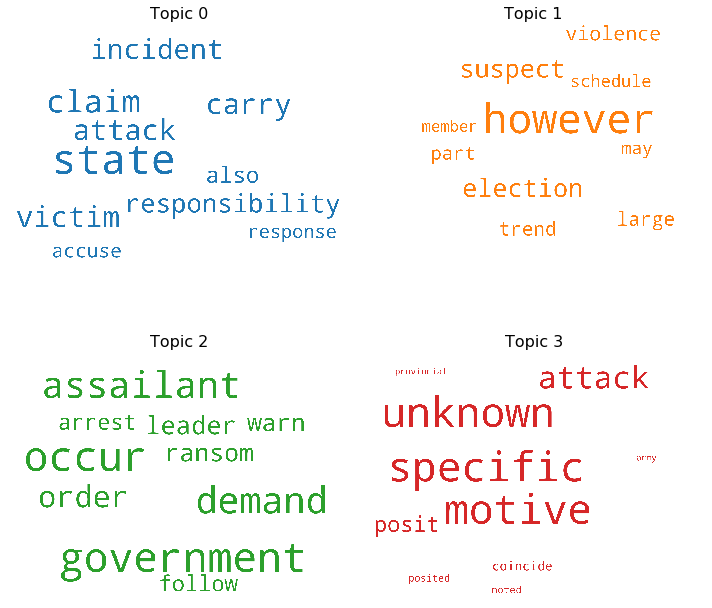

In [20]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

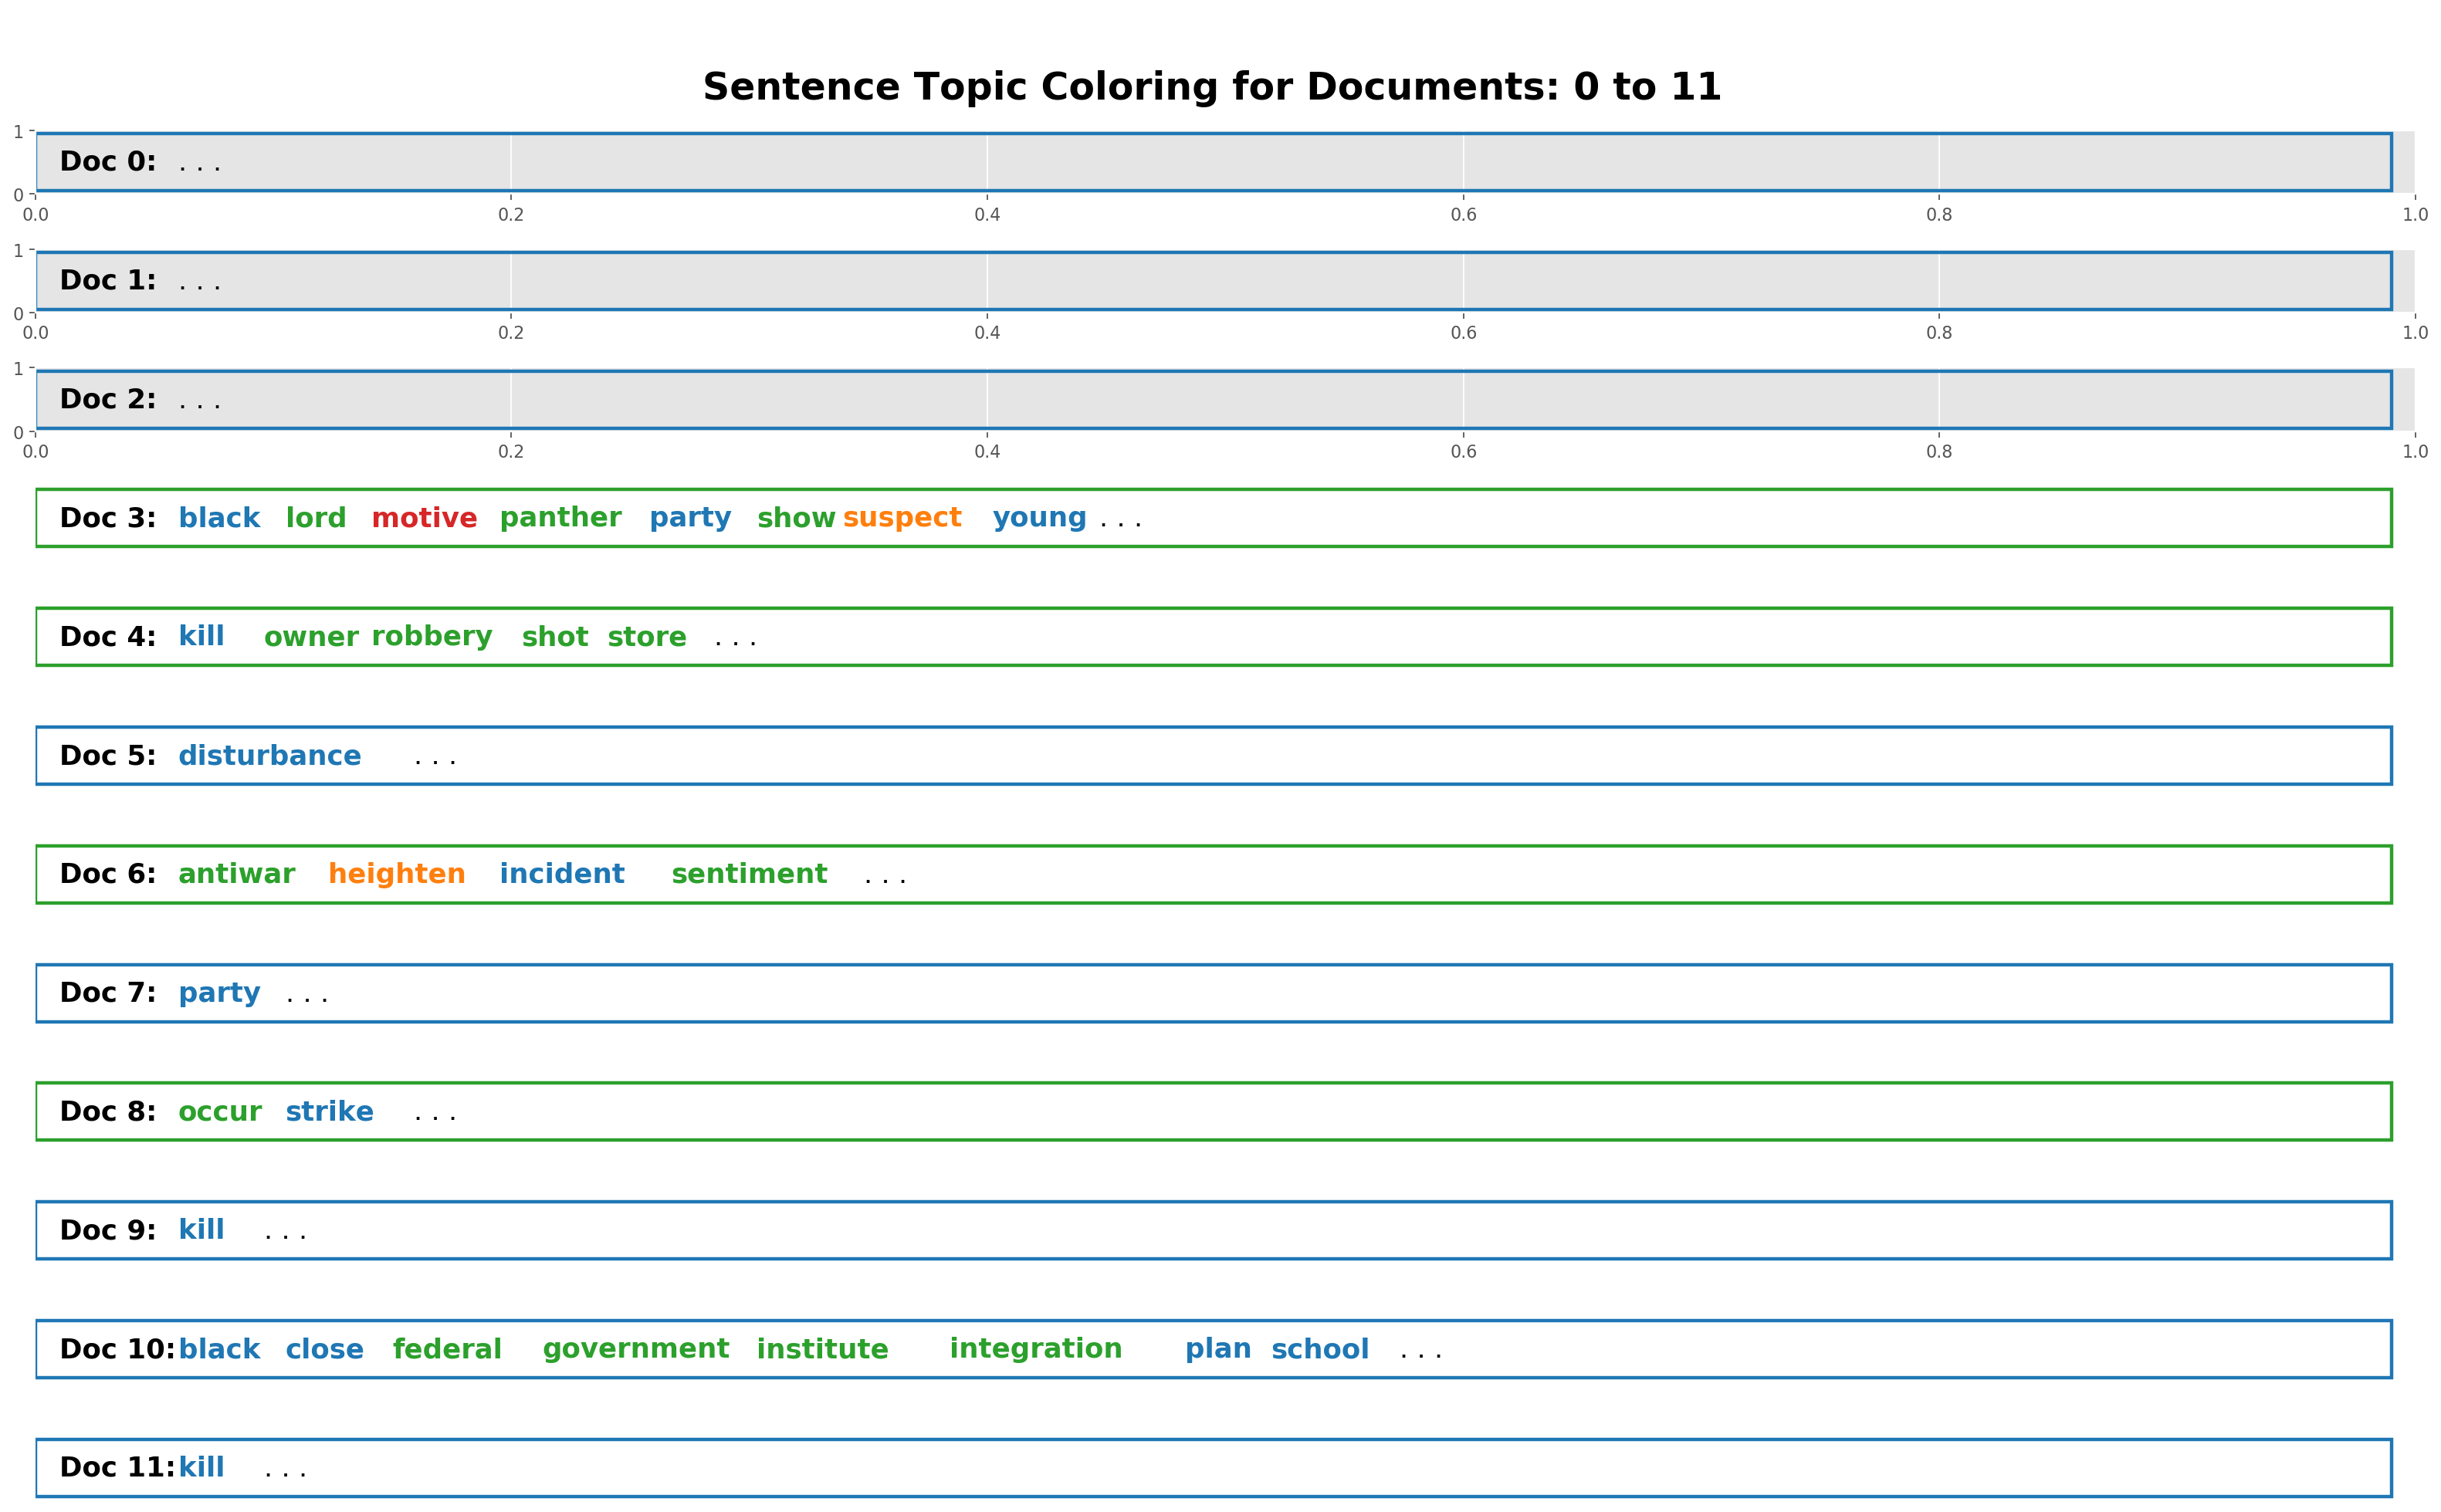

In [21]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [30]:
df_dominant_topic[df_dominant_topic['Document_No']==1]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1,1,0.0,0.25,"state, claim, victim, attack, carry, incident, responsibility, also, accuse, response",[]


In [25]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.253540 -0.129926       1        1  41.437321
0     -0.193972  0.066327       2        1  23.881220
1      0.280981 -0.267952       3        1  19.928844
2      0.166531  0.331551       4        1  14.752613, topic_info=            Term          Freq         Total Category  logprob  loglift
209      however  14302.000000  14302.000000  Default  30.0000  30.0000
215      unknown  22753.000000  22753.000000  Default  29.0000  29.0000
214     specific  22553.000000  22553.000000  Default  28.0000  28.0000
2         motive  22525.000000  22525.000000  Default  27.0000  27.0000
447        state   7395.000000   7395.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
2231      somali    229.451187    230.264420   Topic4  -4.9874   1.9102
739        early    169.802567    170.709702   Topic4  -5.2885   1.9084
1450     project    280.030518    286.193451   Topic4  -4.7882   1.8920
1044   celebrate    178.307098    180.264465   Topic4  -5.2396   1.9028
555   previously    330.355438    438.686371   Topic4  -4.6230   1.6301

[194 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1905      4  0.999407     abduct
1355      4  0.996222  abduction
535       2  0.999278     accuse
539       1  0.927209  affiliate
539       3  0.035662  affiliate
...     ...       ...        ...
289       4  0.999697       want
890       4  0.998466       warn
528       4  0.998637       week
435       2  0.998592       work
416       2  0.996589      would

[241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

#### Thoughts on way forward for modeling
- Data cleaning **[Done]**
**Note: Laptop unable to handle full dataset (181,691) word vectorizatn, able to handle remaining rows (drop null and motive unknown)**
- Research (concurrent) credibility of using motive to classify bombing and non-bombing **[Done]**
    -Target `atkmode` Variable `Vectorized Words in motive`.
- Review class balance **[Done]**
- SMOTE if imbalance **[Current balance seems adequate. Unexpected that bombing incidents can so high]**

- Review the words in bomb and non-bomb atkmodes **[Done]**
- Explore **Spacy** - Entity identification **[Dependency and Visualisation Done]**
- Explore extract noun and adjective 
- Read the motive to understand the structure **[Prelim done]**


- Oriented understanding 
    - model insights extraction (besides NB, such as log reg, or decision tree), top positive / negative words **[Done]**
    - LDA standalone model first
    - LDA drill deeper
- Build Models workflow. How it groups motives (is there a temporal aspect to it?)
- How many words on average in a motive? Primary motive words?


- 1. Classifiers (best of lot)?
- 2. Ensemble?

**!!!Own notes!!!** 
We could review the overlap words and remove them via stopwords to improve the classification capability of the classifier model. The other approach is to utilise LDA (an unsupervised learning technique) to uncover underlying topics in `motive` data, based on word frequency within a document set. Latent topics would be generated for both the "training" and "testing" dataset, to classify text in a documents into topics. **still not too sure how it can fit towards atk mode classification.**